In [ ]:
from zipline.data.bundles.core import load
from zipline.data.bundles import ingest
from dotenv import load_dotenv
import os

load_dotenv()
assert os.getenv("QUANDL_API_KEY"), "Missing QUANDL API KEY"
ingest("quandl")
bundle = load("quandl", os.environ, None)

In [ ]:
import pandas as pd
import numpy as np
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume, CustomFactor, Returns
from zipline.finance import commission, slippage
from zipline.api import (
    attach_pipeline,
    calendars,
    pipeline_output,
    date_rules,
    time_rules,
    set_commission,
    set_slippage,
    record,
    order_target_percent,
    get_open_orders,
    get_datetime,
    schedule_function
)
import pandas_datareader as web

C:\Users\nickt\AppData\Local\Temp\tmp984yy44b\ipykernel_13692\3551296993.py:98: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  benchmark_returns = sp500.pct_change()


2016-01-04 | Longs 0 | Shorts 1 | 100000.0
2016-01-05 | Longs 0 | Shorts 1 | 99999.98349999885
2016-01-06 | Longs 0 | Shorts 1 | 99991.62349999885


c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


2016-01-07 | Longs 0 | Shorts 0 | 99994.48349999885
2016-01-08 | Longs 1 | Shorts 1 | 99991.38699999738
2016-01-11 | Longs 0 | Shorts 1 | 99991.34874999725
2016-01-12 | Longs 1 | Shorts 1 | 100038.53374999725
2016-01-13 | Longs 3 | Shorts 2 | 100091.22374999724
2016-01-14 | Longs 2 | Shorts 1 | 100159.81249999639


c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


2016-01-15 | Longs 1 | Shorts 2 | 99988.38074999627
2016-01-19 | Longs 2 | Shorts 1 | 100002.40474999536
2016-01-20 | Longs 1 | Shorts 2 | 100064.59374999514
2016-01-21 | Longs 1 | Shorts 2 | 100018.97274999478
2016-01-22 | Longs 1 | Shorts 2 | 99960.80274999476
2016-01-25 | Longs 2 | Shorts 2 | 99971.70274999477
2016-01-26 | Longs 2 | Shorts 3 | 99907.20574999462
2016-01-27 | Longs 2 | Shorts 4 | 99892.4789999931
2016-01-28 | Longs 2 | Shorts 4 | 99840.08899999302
2016-01-29 | Longs 2 | Shorts 4 | 99744.52899999304
2016-02-01 | Longs 3 | Shorts 3 | 99653.83899999304
2016-02-02 | Longs 3 | Shorts 3 | 99660.28224998905
2016-02-03 | Longs 3 | Shorts 2 | 99472.39299998811
2016-02-04 | Longs 3 | Shorts 2 | 99473.33199998765
2016-02-05 | Longs 2 | Shorts 1 | 99417.9289999875
2016-02-08 | Longs 2 | Shorts 2 | 99286.00074998729
2016-02-09 | Longs 4 | Shorts 2 | 99308.25749998634
2016-02-10 | Longs 4 | Shorts 1 | 99339.21099998563
2016-02-11 | Longs 2 | Shorts 1 | 99427.1504999856
2016-02-12 |

c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


2016-07-19 | Longs 1 | Shorts 2 | 100878.41349990293
2016-07-20 | Longs 1 | Shorts 1 | 100948.83349990271
2016-07-21 | Longs 1 | Shorts 1 | 101193.7834999024
2016-07-22 | Longs 1 | Shorts 1 | 101174.12349990242
2016-07-25 | Longs 0 | Shorts 2 | 101169.51074990144
2016-07-26 | Longs 0 | Shorts 3 | 101183.02874989921
2016-07-27 | Longs 0 | Shorts 2 | 101193.41074989863
2016-07-28 | Longs 1 | Shorts 3 | 101189.72274989758
2016-07-29 | Longs 0 | Shorts 2 | 101230.39224989596
2016-08-01 | Longs 0 | Shorts 2 | 101134.18974989517
2016-08-02 | Longs 1 | Shorts 2 | 101282.75974989517
2016-08-03 | Longs 0 | Shorts 1 | 101274.14974989419
2016-08-04 | Longs 1 | Shorts 1 | 101307.38374989264
2016-08-05 | Longs 0 | Shorts 2 | 101298.96124989183
2016-08-08 | Longs 1 | Shorts 2 | 101311.5507498902
2016-08-09 | Longs 1 | Shorts 1 | 101309.45599989018
2016-08-10 | Longs 1 | Shorts 1 | 101308.06724988786
2016-08-11 | Longs 1 | Shorts 1 | 101287.21724988786
2016-08-12 | Longs 1 | Shorts 1 | 101279.2972498

c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


2017-01-19 | Longs 0 | Shorts 0 | 102193.21149977428
2017-01-20 | Longs 1 | Shorts 2 | 102228.90024977298
2017-01-23 | Longs 2 | Shorts 1 | 102228.83199977076
2017-01-24 | Longs 3 | Shorts 1 | 102243.38674976854
2017-01-25 | Longs 2 | Shorts 1 | 102197.42899976853
2017-01-26 | Longs 1 | Shorts 3 | 102024.89524976687
2017-01-27 | Longs 2 | Shorts 2 | 102052.8029997651
2017-01-30 | Longs 1 | Shorts 3 | 102093.41774976414
2017-01-31 | Longs 1 | Shorts 3 | 102162.49174976329
2017-02-01 | Longs 1 | Shorts 3 | 102081.37174976329
2017-02-02 | Longs 3 | Shorts 3 | 102133.35174976329
2017-02-03 | Longs 2 | Shorts 4 | 102120.96949976293
2017-02-06 | Longs 2 | Shorts 4 | 102057.80524976215
2017-02-07 | Longs 2 | Shorts 4 | 102019.50524976215
2017-02-08 | Longs 2 | Shorts 3 | 101967.68524976214
2017-02-09 | Longs 2 | Shorts 3 | 101991.4007497385
2017-02-10 | Longs 2 | Shorts 3 | 102050.97349973815
2017-02-13 | Longs 1 | Shorts 4 | 102092.51349973814
2017-02-14 | Longs 1 | Shorts 4 | 102132.1217497

c:\Users\nickt\anaconda3\envs\my-quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


2017-07-20 | Longs 3 | Shorts 3 | 102172.60349954659
2017-07-21 | Longs 5 | Shorts 2 | 102068.68349954578
2017-07-24 | Longs 5 | Shorts 2 | 102104.10474954023
2017-07-25 | Longs 4 | Shorts 1 | 102176.96299953497
2017-07-26 | Longs 4 | Shorts 1 | 102153.7424995342
2017-07-27 | Longs 5 | Shorts 5 | 102445.54749953358
2017-07-28 | Longs 2 | Shorts 4 | 102348.547249531
2017-07-31 | Longs 2 | Shorts 6 | 102291.15949952848
2017-08-01 | Longs 2 | Shorts 6 | 102393.15474952778
2017-08-02 | Longs 1 | Shorts 9 | 102542.00474952745
2017-08-03 | Longs 1 | Shorts 7 | 102507.19849952613
2017-08-04 | Longs 1 | Shorts 8 | 102497.03074952435
2017-08-07 | Longs 1 | Shorts 6 | 102460.59999952393
2017-08-08 | Longs 2 | Shorts 5 | 102401.04799952377
2017-08-09 | Longs 2 | Shorts 7 | 102396.4559995227
2017-08-10 | Longs 1 | Shorts 6 | 102458.30974952244
2017-08-11 | Longs 0 | Shorts 5 | 102393.50224951954
2017-08-14 | Longs 1 | Shorts 4 | 102340.00374951604
2017-08-15 | Longs 1 | Shorts 4 | 102356.253999514

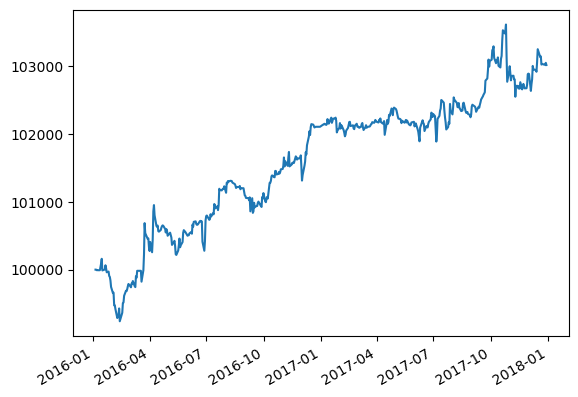

In [50]:
# Number of long and short positions to hold
N_LONGS = N_SHORTS = 50
# Approximate number of trading days in a month and year
MONTH = 21
YEAR = 12 * MONTH

# Custom mean reversion factor using Zipline Pipeline
class MeanReversion(CustomFactor):
    # Use rolling monthly returns as input
    inputs = [Returns(window_length=MONTH)]
    # Look back over a year of monthly returns
    window_length = YEAR
    def compute(self, today, assets, out, monthly_returns):
        # Convert input array to DataFrame for easier manipulation
        df = pd.DataFrame(monthly_returns)
        # Calculate z-score: (last month's return - mean) / std deviation
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

# Build the pipeline for stock selection
def make_pipeline():
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            # Select bottom N_LONGS for long positions (most negative z-scores)
            "longs": mean_reversion.bottom(N_LONGS),
            # Select top N_SHORTS for short positions (most positive z-scores)
            "shorts": mean_reversion.top(N_SHORTS),
            # Rank all assets by mean reversion score (descending)
            "ranking": mean_reversion.rank(),
        },
        # Only consider the 100 most liquid stocks by dollar volume
        screen=dollar_volume.top(100)
    )

# Called before each trading day to get the latest pipeline output
def before_trading_start(context, data):
    # Store pipeline results in context for use in rebalancing
    context.factor_data = pipeline_output("factor_pipeline")

# Initialize the algorithm and set up schedules, commission, and slippage
def initialize(context):
    # Attach the pipeline to the algorithm
    attach_pipeline(make_pipeline(), "factor_pipeline")
    # Schedule weekly rebalancing at market open
    schedule_function(
        rebalance,
        date_rules.every_day(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )
    # Set commission model (per share)
    set_commission(
        us_equities=commission.PerShare(cost=0.00075, min_trade_cost=0.01)
    )
    # Set slippage model (volume share based)
    set_slippage(
        us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01)
    )

# Rebalance portfolio based on pipeline output
def rebalance(context, data):
    factor_data = context.factor_data
    # Record the ranking for later analysis (note: record expects scalars)
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    # Record average price for diagnostics
    record(prices=data.current(assets, "price"))
    # Select assets to long and short
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    # Find assets to fully exit (not in new long/short lists)
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))
    # Print current date, number of longs/shorts, and portfolio value
    print(f"{get_datetime().date()} | Longs {len(longs)} | Shorts {len(shorts)} | {context.portfolio.portfolio_value}")
    # Sell all divested assets
    exec_trades(data, assets=divest, target_percent=0)
    # Set target weights for longs and shorts (currently 100% each; consider splitting weights for neutrality)
    exec_trades(data, assets=longs, target_percent=1/N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1/N_SHORTS)

# Helper function to place orders for a list of assets
def exec_trades(data, assets, target_percent):
    for asset in assets:
        # Only trade if asset is tradable and no open orders exist
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

# Plot portfolio value at the end of the backtest
def analyze(context, perf):
    perf.portfolio_value.plot()

# Set up backtest parameters
start = pd.Timestamp("2016")
end = pd.Timestamp("2018")
# Get S&P 500 index data from FRED for benchmark returns
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

# Run the backtest with all the above settings
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    benchmark_returns=benchmark_returns,
    before_trading_start=before_trading_start,
    capital_base=100_000,
    bundle="quandl"
)
# Save results to a file for later analysis
perf.to_pickle("mean_reversion.pickle")


In [48]:
import pyfolio as pf
import matplotlib.pyplot as plt
from openbb import obb
obb.user.preferences.output_type = "dataframe"
perf = pd.read_pickle('mean_reversion.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
positions.columns = [
    col.symbol for col in positions.columns[:-1]]+["cash"]
transactions.symbol = transactions.symbol.apply(lambda s: s.symbol)
symbols = positions.columns[:-1].tolist()
screener_data = obb.equity.profile(symbols,provider="yfinance")
sector_map = (
    screener_data[["symbol","sector"]]
    .set_index("symbol")
    .reindex(symbols)
    .fillna("Unknown")
    .to_dict()["sector"]
)
sector_map


404 Client Error:  for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/BRK_B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=BRK_B&crumb=sRjEr.zbRu3


{'AAL': 'Industrials',
 'AAPL': 'Technology',
 'ABBV': 'Healthcare',
 'ADBE': 'Technology',
 'ADP': 'Technology',
 'AET': 'Unknown',
 'AGN': 'Unknown',
 'AIG': 'Financial Services',
 'ALXN': 'Unknown',
 'AMAT': 'Technology',
 'AMGN': 'Healthcare',
 'AMZN': 'Consumer Cyclical',
 'ANTM': 'Unknown',
 'ARIA': 'Unknown',
 'ATVI': 'Unknown',
 'AVGO': 'Technology',
 'AXP': 'Financial Services',
 'AZO': 'Consumer Cyclical',
 'BA': 'Industrials',
 'BBY': 'Consumer Cyclical',
 'BCR': 'Unknown',
 'BIDU': 'Communication Services',
 'BIIB': 'Healthcare',
 'BMY': 'Healthcare',
 'BRK_B': 'Unknown',
 'CCE': 'Unknown',
 'CELG': 'Unknown',
 'CHTR': 'Communication Services',
 'CL': 'Consumer Defensive',
 'CMCSA': 'Communication Services',
 'CMG': 'Consumer Cyclical',
 'COL': 'Unknown',
 'COST': 'Consumer Defensive',
 'CSCO': 'Technology',
 'CSX': 'Industrials',
 'CTSH': 'Technology',
 'CVS': 'Healthcare',
 'DAL': 'Industrials',
 'DE': 'Industrials',
 'DG': 'Consumer Defensive',
 'DVN': 'Energy',
 'EA': '